In [21]:
%load_ext autoreload
%autoreload 2
import numpy as np
import popstock
import bilby
from popstock_tsf_helper import *

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.color'] = 'grey'
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.labelsize'] = 22
mpl.rcParams['legend.handlelength'] = 3
mpl.rcParams['legend.fontsize'] = 20

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
#rc('text', usetex=True)
from scipy.interpolate import interp1d
import lal
lal.swig_redirect_standard_output_error(False)

import transdimensional_spline_fitting as tsf
import gwpopulation.models
from gwpopulation.models.mass import SinglePeakSmoothedMassDistribution
from gwpopulation.models.redshift import MadauDickinsonRedshift
from popstock.PopulationOmegaGW import PopulationOmegaGW

# Class factory that creates class with correct parameter names that we will sample over
def createSplineRedshift(max_knots=10):
    class SplineRedshift(gwpopulation.models.redshift._Redshift):
        r"""
        Redshift model from Fishbach+ https://arxiv.org/abs/1805.10270 (33)
        See https://arxiv.org/abs/2003.12152 (2) for the normalisation
    
        The parameterisation differs a little from there, we use
    
        .. math::
            p(z|\gamma, \kappa, z_p) &\propto \frac{1}{1 + z}\frac{dV_c}{dz} \psi(z|\gamma, \kappa, z_p)
    
            \psi(z|\gamma, \kappa, z_p) &= \frac{(1 + z)^\gamma}{1 + (\frac{1 + z}{1 + z_p})^\kappa}
    
        Parameters
        ----------
        gamma: float
            Slope of the distribution at low redshift
        kappa: float
            Slope of the distribution at high redshift
        z_peak: float
            Redshift at which the distribution peaks.
        z_max: float, optional
            The maximum redshift allowed.
        """
        variable_names = [f"amplitudes{ii}" for ii in range(max_knots)] + \
                              [f"configuration{ii}" for ii in range(max_knots)] + \
                              [f"xvals{ii}" for ii in range(max_knots)]
    
        def psi_of_z(self, redshift, **parameters):
            amplitudes = np.array([parameters[key] for key in parameters if 'amplitude' in key])
            configuration = np.array([parameters[key] for key in parameters if 'configuration' in key])
            xvals = np.array([parameters[key] for key in parameters if 'xval' in key])
            return interp1d(xvals[configuration], amplitudes[configuration], fill_value="extrapolate")(redshift)
    return SplineRedshift

class NewModel(tsf.BaseSplineModel):
    def ln_likelihood(self, config, heights, knots):
        # construct what needs to go into calculating omega_gw
        params = {**{f'amplitudes{ii}': heights[ii] for ii in range(heights.size)},
                  **{f'configuration{ii}': config[ii] for ii in range(config.size)},
                  **{f'xvals{ii}': knots[ii] for ii in range(self.available_knots.size)},
                        **Lambda_0}
        patpop_sample.calculate_omega_gw(params)
        return np.sum(-0.5 * (fake_data - patpop_sample.omega_gw)**2 / (2 * sigma**2))

class SplineRedshift(gwpopulation.models.redshift._Redshift):
    """
    Redshift model from Fishbach+ https://arxiv.org/abs/1805.10270 (33)
    See https://arxiv.org/abs/2003.12152 (2) for the normalisation

    The parameterisation differs a little from there, we use

    .. math::
        p(z|\gamma, \kappa, z_p) &\propto \frac{1}{1 + z}\frac{dV_c}{dz} \psi(z|\gamma, \kappa, z_p)

        \psi(z|\gamma, \kappa, z_p) &= \frac{(1 + z)^\gamma}{1 + (\frac{1 + z}{1 + z_p})^\kappa}

    Parameters
    ----------
    gamma: float
        Slope of the distribution at low redshift
    kappa: float
        Slope of the distribution at high redshift
    z_peak: float
        Redshift at which the distribution peaks.
    z_max: float, optional
        The maximum redshift allowed.
    """
    base_variable_names = ["gamma", "kappa", "z_peak"]

    def psi_of_z(self, redshift, **parameters):
        amplitudes = np.array([parameters[key] for key in parameters if 'amplitude' in key])
        configuration = np.array([parameters[key] for key in parameters if 'configuration' in key])
        xvals = np.array([params[key] for key in parameters if 'xval' in key])
        print(parameters.keys())
        return interp1d(xvals[configuration], amplitudes[configuration], fill_value="extrapolate")(redshift)

def create_popOmegaGW(freqs, mass_obj, redshift_obj):
    # choose models for calculating Omega_GW
    models = {'mass_model' : mass_obj,'redshift_model' : redshift_obj,}
    # Populations object requires mass and redshift distributions and frequencies
    pop_obj = PopulationOmegaGW(models=models, frequency_array=freqs)
    return pop_obj

# functions for running the popstock fitter with specified desired parameters
def create_injected_OmegaGW(freqs, Lambda_0, N_proposal_samples, mass_obj, redshift_obj):
    # create population object
    newpop = create_popOmegaGW(freqs, mass_obj, redshift_obj)
    
    # We need to define Λ_0 hyperparameters for population (must match formalism in the redshifta nd mass models) and number of desired samples
    newpop.draw_and_set_proposal_samples(Lambda_0, N_proposal_samples=N_proposal_samples)

    # Calculates Ω_GW
    newpop.calculate_omega_gw(Lambda=Lambda_0, multiprocess=True)

    # create a new set of Lambdas, with a different value of alpha
    newpop.calculate_omega_gw(Lambda=Lambda_0)

    # additional arguments needed to pass into sampling to use the spline redshift model
    args = np.argsort(newpop.proposal_samples['redshift'])
    xvals = newpop.proposal_samples['redshift'][args][::10000]
    amplitudes = newpop.models['redshift'].psi_of_z(newpop.proposal_samples['redshift'], **Lambda_0)[args][::10000]
    configuration = np.ones(amplitudes.size, dtype=bool)

    # Keep the mass model the same, redshift model becomes the spline redshift
    splredshift = createSplineRedshift(amplitudes.size)(z_max=10)
    models_pat = {'mass_model' : mass_obj,'redshift_model' : splredshift}

    # instantiate population object using the spline redshift model 
    patpop = PopulationOmegaGW(models=models_pat, frequency_array=freqs)

    # define the hyperparameters (need additional ones to Λ to match additional parameters needed for the spline redshift model)
    params_start = {**{f'amplitudes{ii}': amplitudes[ii] for ii in range(amplitudes.size)}, **{f'xvals{ii}': xvals[ii] for ii in range(xvals.size)}, **{f'configuration{ii}': configuration[ii] for ii in range(configuration.size)}}
    Lambda_start = {**params_start, **Lambda_0}
    N_proposal_samples = int(4.e4)

    # sample and calulate Ω_GW for spline redshift model
    patpop.draw_and_set_proposal_samples(Lambda_start, N_proposal_samples=N_proposal_samples)
    patpop.calculate_omega_gw(Lambda=Lambda_start, multiprocess=True)

    return xvals, patpop, newpop, amplitudes, configuration, Lambda_start

# split this into two functions and return patpop_sample so that it can work globally in the likelihood function
def sample_for_redshift(N_proposal_samples, xvals, fake_data, patpop_sample, amplitudes, configuration, Lambda_start, Lambda_0):
    patpop_sample.draw_and_set_proposal_samples(Lambda_start, N_proposal_samples=N_proposal_samples)
    patpop_sample.calculate_omega_gw(Lambda=Lambda_start, multiprocess=True)

    pat_model = NewModel(fake_data, amplitudes.size, (0.01, 10), (0, 20), min_knots=2)
    pat_model.ln_likelihood(np.ones(pat_model.N_possible_knots, dtype=bool), amplitudes, xvals)

    params_start = {**{f'amplitudes{ii}': amplitudes[ii] for ii in range(amplitudes.size)},
            **{f'xvals{ii}': xvals[ii] for ii in range(xvals.size)},
            **{f'configuration{ii}': configuration[ii] for ii in range(configuration.size)}}
    Lambda_start = {**params_start, **Lambda_0}

    # results becomes our Sampler object that we can stick in the functions above
    results = pat_model.sample(int(N_proposal_samples/10), start_heights=amplitudes)
    interp1d(pat_model.available_knots[pat_model.configuration], pat_model.current_heights[pat_model.configuration], fill_value='extrapolate')(patpop_sample.proposal_samples['redshift'])
    
    return results, patpop_sample, Lambda_start, pat_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define Variables

In [2]:
# variables for generating injected Omega_GW
freqs = np.arange(10, 2000, 2.5)
Lambda_0 =  {'alpha': 2.5, 'beta': 1, 'delta_m': 3, 'lam': 0.04, 'mmax': 100, 'mmin': 4, 'mpp': 33, 'sigpp':5, 'gamma': 2.7, 'kappa': 3, 'z_peak': 1.9, 'rate': 15}
N_proposal_samples1 = int(1.e5)

# variables for sampling the redshift distribution that calculates Omega_GW
sigma = 1e-10
N_proposal_samples2 = 20_000

mass_obj = SinglePeakSmoothedMassDistribution()
redshift_obj = MadauDickinsonRedshift(z_max=10)

# Running Omega_GW generator and fitter

Initializing with the following models: 
mass: <gwpopulation.models.mass.SinglePeakSmoothedMassDistribution object at 0x7fa0614f7d30>
redshift: <gwpopulation.models.redshift.MadauDickinsonRedshift object at 0x7fa0614f7fd0>
Using 10000000, got 54901 out of target 100000 samples after iteration 0
Efficiency: 0.0054901, trying 8214604 samples in next iteration
-----------------------------------------------------------
Using 8214604, got 99867 out of target 100000 samples after iteration 1
Efficiency: 0.005473909637031803, trying 10053874 samples in next iteration
-----------------------------------------------------------


13:45 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Using 10053874, got 155003 out of target 100000 samples after iteration 2
Efficiency: 0.005484055201010078, trying 8180807 samples in next iteration
-----------------------------------------------------------
Drawing redshift samples
{'gamma': 2.7, 'kappa': 3, 'z_peak': 1.9}
Using multiprocessing, no status bar currently supported... 
Initializing with the following models: 
mass: <gwpopulation.models.mass.SinglePeakSmoothedMassDistribution object at 0x7fa0614f7d30>
redshift: <__main__.createSplineRedshift.<locals>.SplineRedshift object at 0x7fa06153a640>
Using 4000000, got 22031 out of target 40000 samples after iteration 0
Efficiency: 0.00550775, trying 3262493 samples in next iteration
-----------------------------------------------------------
Using 3262493, got 39929 out of target 40000 samples after iteration 1
Efficiency: 0.005485988782198153, trying 4028808 samples in next iteration
-----------------------------------------------------------


13:46 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Using 4028808, got 62199 out of target 40000 samples after iteration 2
Efficiency: 0.005527689579647379, trying 3207488 samples in next iteration
-----------------------------------------------------------
Drawing redshift samples
{'amplitudes0': 1.150916960308196, 'amplitudes1': 7.270623540564795, 'amplitudes2': 9.57330864393058, 'amplitudes3': 11.127106484734524, 'amplitudes4': 12.175955351699033, 'amplitudes5': 12.85053438044087, 'amplitudes6': 13.220506846473905, 'amplitudes7': 13.326745497284806, 'amplitudes8': 13.18925179211921, 'amplitudes9': 12.805837420045464, 'configuration0': True, 'configuration1': True, 'configuration2': True, 'configuration3': True, 'configuration4': True, 'configuration5': True, 'configuration6': True, 'configuration7': True, 'configuration8': True, 'configuration9': True, 'xvals0': 0.05616945042142999, 'xvals1': 1.4439160296827895, 'xvals2': 1.9942339479076825, 'xvals3': 2.505495246663014, 'xvals4': 3.0300493135654416, 'xvals5': 3.607394861484876, 'xval

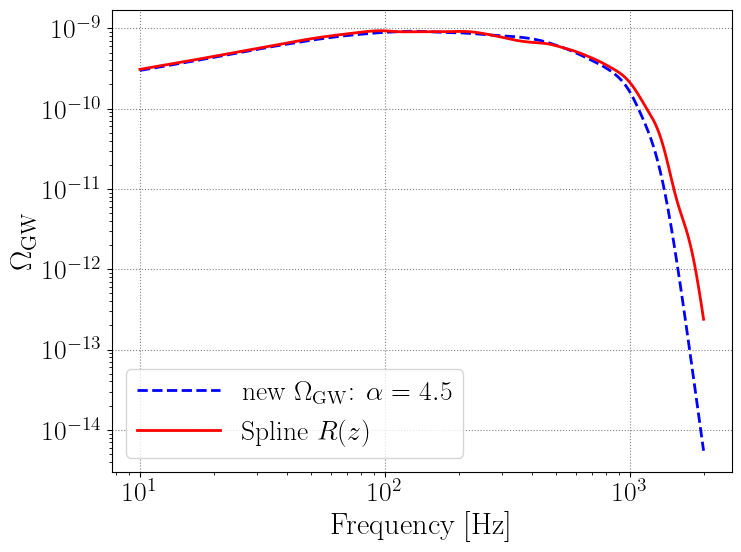

In [3]:
xvals, patpop, newpop, amplitudes, configuration, Lambda_start = create_injected_OmegaGW(freqs, Lambda_0, N_proposal_samples1, mass_obj, redshift_obj)

# plotting everything
plt.loglog(newpop.frequency_array, newpop.omega_gw, color='blue', linestyle='--', label=r'new $\Omega_{\rm GW}$: $\alpha=4.5$')
plt.loglog(newpop.frequency_array, patpop.omega_gw, color='red', linestyle='-', label='Spline $R(z)$')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'$\Omega_{\rm GW}$')
plt.legend()

In [6]:
fake_data = np.random.randn(patpop.omega_gw.size) * sigma + patpop.omega_gw

splredshift_lowknots = createSplineRedshift(amplitudes.size)(z_max=10)
patpop_sample = create_popOmegaGW(freqs, mass_obj, splredshift_lowknots)

results, patpop_sample, Lambda_start, pat_model = sample_for_redshift(N_proposal_samples2, xvals, fake_data, patpop_sample, amplitudes, configuration, Lambda_start, Lambda_0)

Initializing with the following models: 
mass: <gwpopulation.models.mass.SinglePeakSmoothedMassDistribution object at 0x7fa0614f7d30>
redshift: <__main__.createSplineRedshift.<locals>.SplineRedshift object at 0x7fa049cae1f0>
Using 2000000, got 11033 out of target 20000 samples after iteration 0
Efficiency: 0.0055165, trying 1625487 samples in next iteration
-----------------------------------------------------------


13:49 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Using 1625487, got 20049 out of target 20000 samples after iteration 1
Efficiency: 0.005546645405346213, trying 1980296 samples in next iteration
-----------------------------------------------------------
Drawing redshift samples
{'amplitudes0': 1.150916960308196, 'amplitudes1': 7.270623540564795, 'amplitudes2': 9.57330864393058, 'amplitudes3': 11.127106484734524, 'amplitudes4': 12.175955351699033, 'amplitudes5': 12.85053438044087, 'amplitudes6': 13.220506846473905, 'amplitudes7': 13.326745497284806, 'amplitudes8': 13.18925179211921, 'amplitudes9': 12.805837420045464, 'configuration0': True, 'configuration1': True, 'configuration2': True, 'configuration3': True, 'configuration4': True, 'configuration5': True, 'configuration6': True, 'configuration7': True, 'configuration8': True, 'configuration9': True, 'xvals0': 0.05616945042142999, 'xvals1': 1.4439160296827895, 'xvals2': 1.9942339479076825, 'xvals3': 2.505495246663014, 'xvals4': 3.0300493135654416, 'xvals5': 3.607394861484876, 'xval

100%|██████████| 2000/2000 [03:30<00:00,  9.49it/s]


# Results Diagnostics

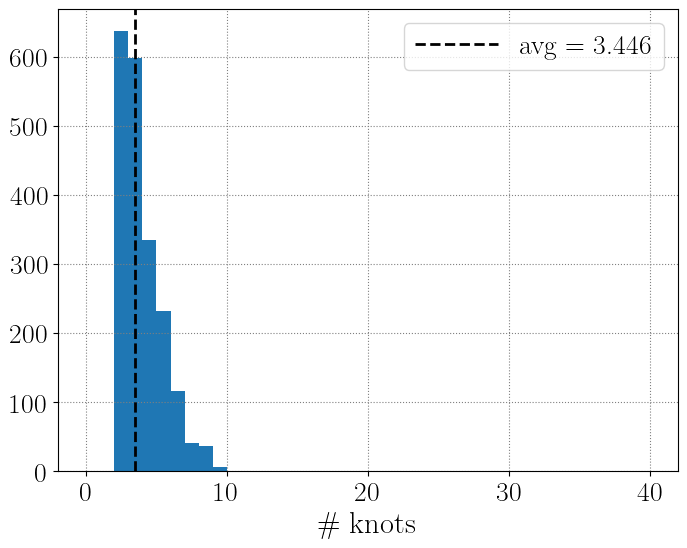

In [23]:
knot_configs, num_knots = return_knot_info(results)

plt.hist(num_knots, bins=np.linspace(0, 20, num=41))
plt.xlabel('$\#$ knots')
plt.axvline(np.average(num_knots), label = 'avg = '+str(np.average(num_knots)), linestyle='--', c='black')
plt.legend()
plt.show()

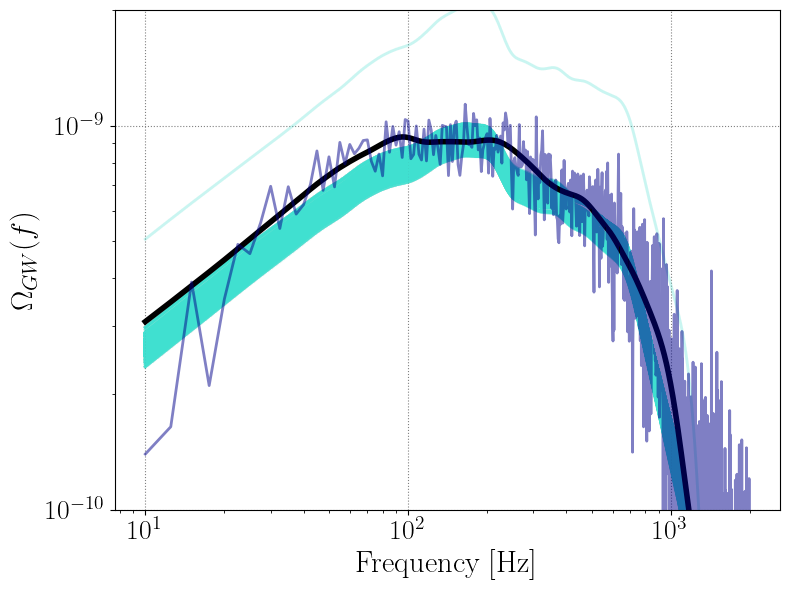

In [24]:
patpop.calculate_omega_gw(Lambda_start)

sample_omegas = []
for kk in range(0,int(len(results.heights))):
    params = {**{f'amplitudes{ii}': results.heights[kk,ii] for ii in range(results.heights[kk].size)},
                **{f'configuration{ii}': results.configurations[kk,ii].astype(bool) for ii in range(results.configurations[kk].size)},
                **{f'xvals{ii}': pat_model.available_knots[ii] for ii in range(pat_model.available_knots.size)},
                **Lambda_0}
    patpop_sample.calculate_omega_gw(params)
    sample_omegas.append(patpop_sample.omega_gw)
    plt.plot(freqs, patpop_sample.omega_gw, alpha=0.1, color = 'turquoise')

patpop.calculate_omega_gw(Lambda_start)

plt.plot(freqs, patpop.omega_gw, lw=4, color = 'black')
plt.plot(freqs, fake_data, color = 'darkblue', alpha = 0.5)
plt.yscale("log")
plt.ylim(1e-10, 2e-9)
plt.xscale("log")
plt.xlabel('Frequency [Hz]')
plt.ylabel('$\Omega_{GW}(f)$ ')
plt.tight_layout()

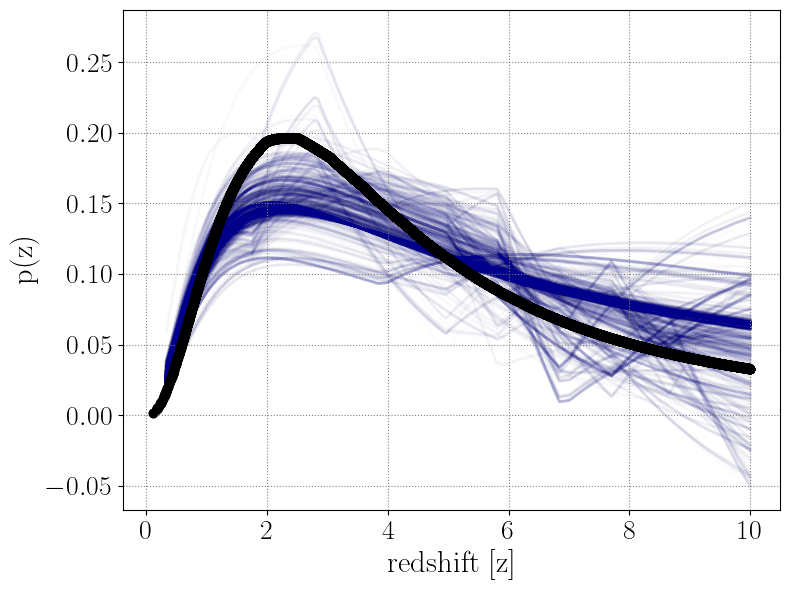

In [25]:
from scipy.stats import norm
from scipy.optimize import curve_fit

sample_probabilities = []
for kk in range(0,2000):
    params = {**{f'amplitudes{ii}': results.heights[kk,ii] for ii in range(results.heights[kk].size)},
              **{f'configuration{ii}': results.configurations[kk,ii].astype(bool) for ii in range(results.configurations[kk].size)},
              **{f'xvals{ii}': pat_model.available_knots[ii] for ii in range(pat_model.available_knots.size)},
              **Lambda_0}
    redshift = patpop_sample.models['redshift'].probability(patpop_sample.proposal_samples, **params)
    sample_probabilities.append(redshift[::100])

    coordinates = list(zip(patpop_sample.proposal_samples['redshift'][::100], redshift[::100]))
    coordinates.sort()
    x_sorted, y_sorted = zip(*coordinates)
    x_sorted = list(x_sorted)
    y_sorted = list(y_sorted)

    plt.plot(x_sorted, y_sorted, alpha=0.01, color = 'darkblue', zorder=0)

plt.scatter(patpop_sample.proposal_samples['redshift'], patpop_sample.models['redshift'].probability(patpop_sample.proposal_samples, **Lambda_start), zorder = 1001, c='black')

plt.xlabel('redshift [z]')
plt.ylabel('p(z)')
plt.tight_layout()

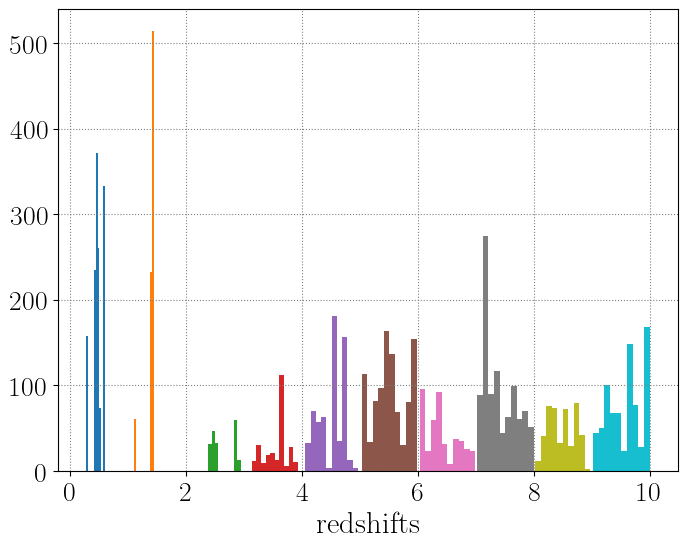

In [28]:
# plotting histogram of horizontal knot placement, should recover vertices in the injected signal
edges, weights = return_knot_placements(results)
plt.xlabel('redshifts')
plt.show()